In [23]:
from operator import add
from typing import Annotated

from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, RemoveMessage
from langgraph.errors import InvalidUpdateError
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from IPython.display import Image, display

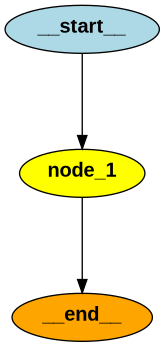

--- Node 1 ---


{'foo': 2}

In [3]:
class State(TypedDict):
    foo: int


def node_1(state):
    print("--- Node 1 ---")
    return {"foo": state['foo'] + 1}


builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

graph.invoke({"foo": 1})

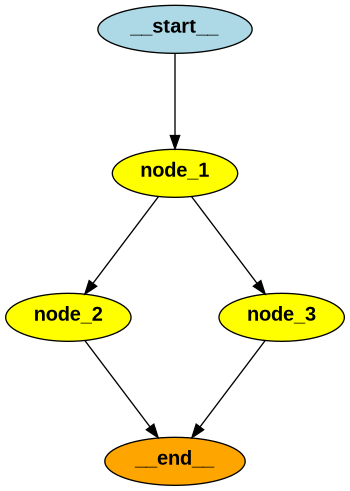

--- Node 1 ---
--- Node 2 ---
--- Node 3 ---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [6]:
class State(TypedDict):
    foo: int


def node_1(state):
    print("--- Node 1 ---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("--- Node 2 ---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("--- Node 3 ---")
    return {"foo": state['foo'] + 1}

builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

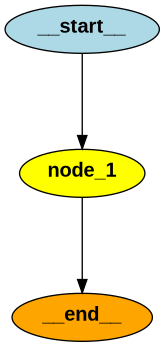

--- Node 1 ---


{'foo': [1, 2]}

In [9]:
class State(TypedDict):
    foo: Annotated[list[int], add]


def node_1(state):
    print("--- Node 1 ---")
    return {"foo": [state['foo'][0] + 1]}


builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

graph.invoke({"foo": [1]})


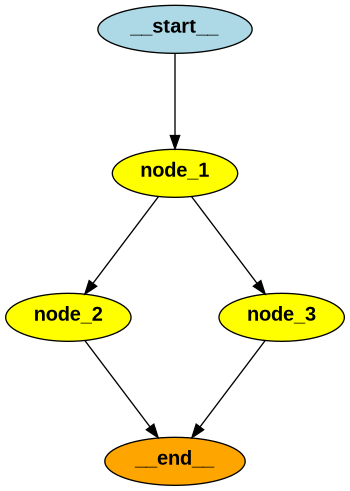

--- Node 1 ---
--- Node 2 ---
--- Node 3 ---


{'foo': [1, 2, 3, 3]}

In [10]:
def node_1(state):
    print("--- Node 1 ---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("--- Node 2 ---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("--- Node 3 ---")
    return {"foo": [state['foo'][-1] + 1]}


builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

graph.invoke({"foo" : [1]})

In [11]:
try:
    graph.invoke({"foo": None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


In [13]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

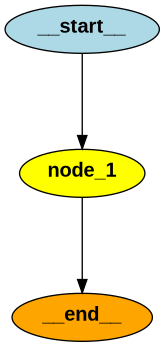

TypeError occurred: can only concatenate list (not "NoneType") to list


In [14]:
def node_1(state):
    print("--- Node 1 ---")
    return {"foo": [2]}

builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

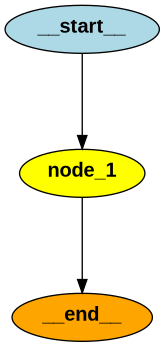

--- Node 1 ---
{'foo': [2]}


In [15]:
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

In [19]:
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str


class ExtendedMessagesState(MessagesState):
    added_key_1: str
    added_key_2: str

In [21]:
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
]

new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='115e0fec-75ba-4b5a-85e9-e39200101b72'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='b9d7ab35-339d-4c5b-8e70-cf8b9ac55f49'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='da0ee8ff-9d48-461d-8054-1c5ac5b53ad9')]

In [22]:
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
]

new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

In [27]:
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [28]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]